In [1]:
from models.Unet import UNet
from dataset.data import BatchMaker
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)


In [2]:
BATCH = 1
path_to_config = '/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
#path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model'


annotator1 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'all',segment = 'mixed',annotator= 1)
train_GT1 = annotator1.train_loader
annotator2 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'all',segment = 'mixed',annotator= 2)
train_GT2 = annotator2.train_loader


/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/train


KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt 

labels1 = []
labels2 = []
for i in range(len(train_GT1.dataset)):
    labels1.append(train_GT1.dataset.__getitem__(i)[1][0])
    labels2.append(train_GT2.dataset.__getitem__(i)[1][0])



In [33]:
label1np = np.array(labels1)
label2np = np.array(labels2)

In [48]:
#IoU = jaccard_score(label1np, label2np)
classes = np.unique(np.concatenate((label1np.flatten(), label2np.flatten())))
jaccard_scores = []
#average_precision = average_precision_score(label1np.flatten(), label2np.flatten())


for cls in classes:
    true_mask = (label2np.flatten() == cls)
    pred_mask = (label1np.flatten() == cls)

    intersection = np.sum(true_mask & pred_mask)
    union = np.sum(true_mask | pred_mask)

    jaccard = intersection / union if union > 0 else 0
    jaccard_scores.append(jaccard)

# Average the Jaccard scores across all classes
average_jaccard = np.mean(jaccard_scores)

print("Jaccard scores for each class:", jaccard_scores)

#print("IoU: {}".format(IoU))
#print("Average Precision: {}".format(average_precision))    

Jaccard scores for each class: [0.9939750840052808, 0.722969509149901, 0.3689429403379839]


In [53]:
import tensorflow as tf

score = tf.keras.metrics.MeanIoU(num_classes=3)
score.update_state(label1np.flatten(), label2np.flatten())
score.result().numpy()

1.0

In [9]:
from models.Unet import UNet
from dataset.data import BatchMaker
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)

num_classes = 3
BATCH = 1
path_to_config = '/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
#path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model_2'


batch_maker = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'test',segment = 'mixed',annotator= 1)
test_loader = batch_maker.test_loader



def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4,figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sperm Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Sperm Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Sperm Image Predicted')
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Sperm Mask Image Predicted binary')
    ax[3].set_axis_off()
    plt.savefig(config['save_inf_fig_path']+'/{}.png'.format(ix))
    plt.close()


if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)  
    print("GPU dostępne:", gpu_name ) 
    device = torch.device("cuda")
else:
    raise Exception("Brak dostępnej karty GPU.")

model = UNet(3,num_classes)
model.load_state_dict(torch.load(model_path)) 
model.to(device)
model.eval() 

# Listy do przechowywania obrazów wejściowych, predykcji i etykiet 
input_images = []
predicted_masks = []
true_masks = []  

# Pętla do przewidywania na danych testowych
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

    
        input_images.append(inputs.cpu())
        predicted_masks.append(outputs.cpu())
        true_masks.append(labels.cpu())  

input_images = np.concatenate(input_images, axis=0)
true_masks = np.concatenate(true_masks, axis=0) 
predicted_masks = torch.cat(predicted_masks, dim=0).cpu().numpy() 

# Threshold predictions
x_images = input_images#.transpose((0, 2, 3, 1))
true = true_masks#.reshape(119, 512, 512)
pred = predicted_masks#.reshape(119, 512, 512)

threshold = 0.5
true_masks_t = (true > threshold).astype(np.uint8)
predicted_masks_t = (pred > threshold).astype(np.uint8)


/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/test
GPU dostępne: NVIDIA GeForce RTX 2060


In [10]:
! nvidia-smi

/bin/bash: /home/marcin/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Nov 26 01:29:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060         On | 00000000:01:00.0 Off |                  N/A |
| 62%   56C    P2               38W / 170W|   3900MiB /  6144MiB |      2%      Default |
|                                      

In [11]:
x_images = input_images.transpose((0, 2, 3, 1))
true = true_masks.transpose((0, 2, 3, 1))
pred = predicted_masks.transpose((0, 2, 3, 1))



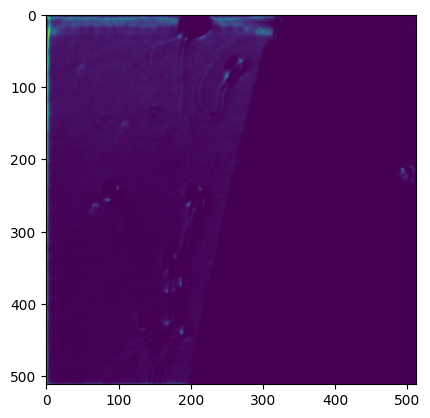

In [6]:
import cv2

image1 = pred[0, :, :, 0]
image2 = pred[0, :, :, 2]
combined_image = cv2.addWeighted(image1, 1, image2, 1, 0)

# Przekształć maski binarne na obrazy RGB
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_GRAY2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_GRAY2RGB)

image1_rgb[np.where((image1_rgb>[0,0,0]).all(axis=2))] = [255,0,0]
image2_rgb[np.where((image2_rgb>[0,0,0]).all(axis=2))] = [0,255,0]

# Połącz obrazy w jedną macierz
combined_image = cv2.addWeighted(image1_rgb, 1, image2_rgb, 1, 0)

# Wyświetl połączone zdjęcie
plt.imshow(image2)
plt.show()



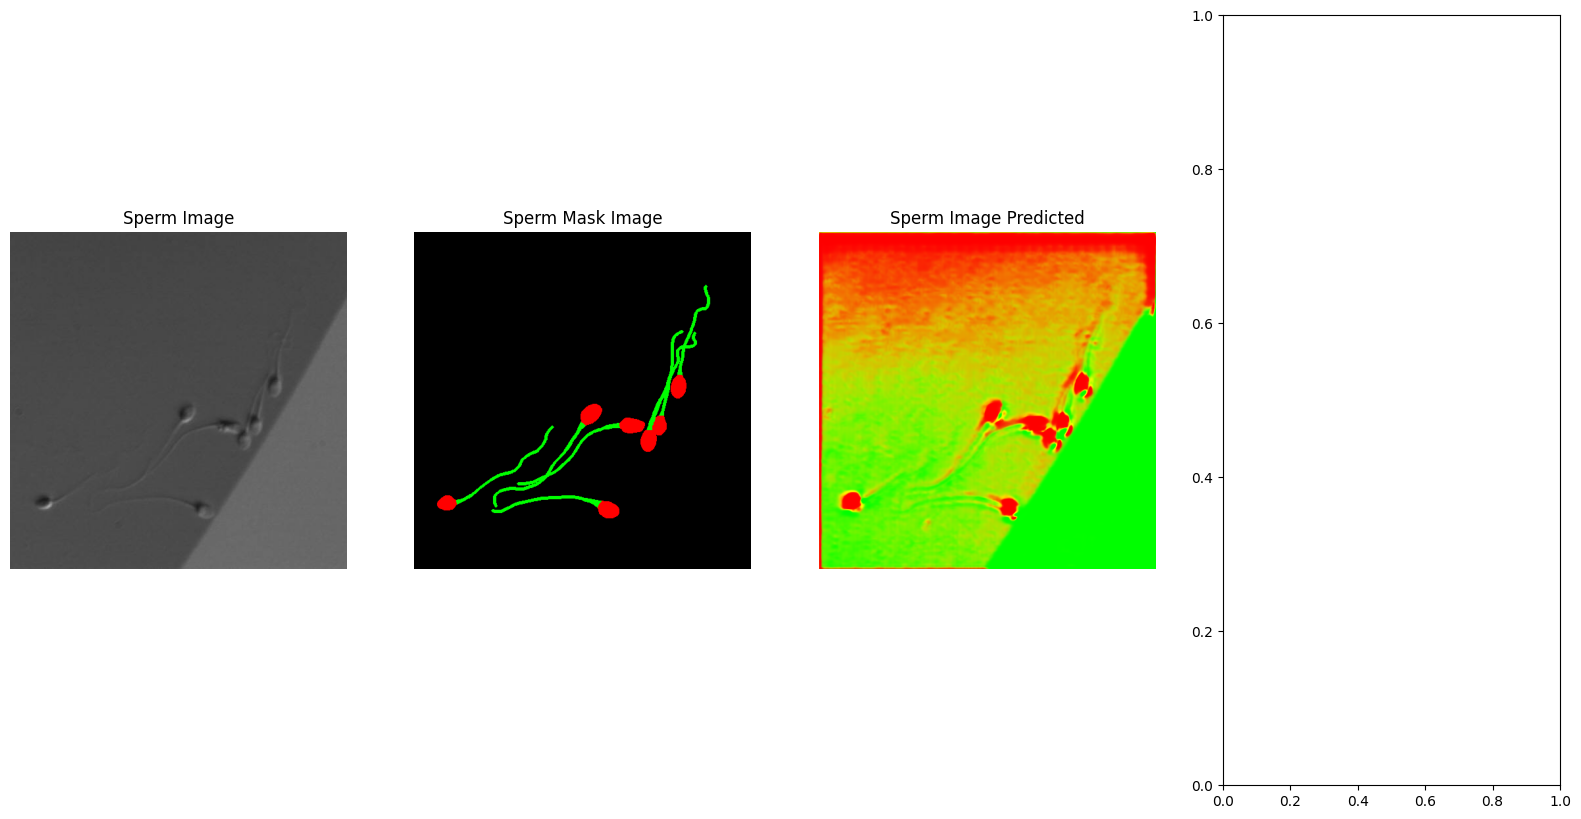

In [14]:

number = 5


fig, ax = plt.subplots(1, 4,figsize=(20, 10))
ax[0].imshow(x_images[number], cmap='seismic')
ax[0].set_title('Sperm Image')
ax[0].set_axis_off()
ax[1].imshow(true[number].squeeze())
ax[1].set_title('Sperm Mask Image')
ax[1].set_axis_off()
ax[2].imshow(pred[number].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
ax[2].set_title('Sperm Image Predicted')
ax[2].set_axis_off()